# How to open Data Files

***

## Imports

- *numpy* to handle array operations
- *asdf* to handle ASDF input/output
- *roman_datamodels* to handle input/output and validation of data models
- *matplotlib.pyplot* for plotting data
- *astropy.units* to handle units

In [2]:
%matplotlib inline
import numpy as np
import asdf
import roman_datamodels as rdm
import matplotlib.pyplot as plt
import astropy.units as u

## Introduction
The main goal of this notebook is to illustrate how to open and handle Roman data.

Roman data are stored in [Advanced Scientific Data Format (ASDF)](https://asdf-standard.readthedocs.io/) files.

ASDF files are files with human-readable hierarchical metadata structure, with binary array data. ASDF data structure can be automatically validated.

There are tools to interact with ASDF files in Python, Julia, C/C++, and IDL. In this example we focus on the Python interface.


***

## Quick start



We will start by illustrating how to read the data using the basic `asdf` library.

The main avenue to read an ASDF file is via the `open` method in the `asdf` package. This returns an `AsdfObject` object.

In [3]:
# This is just an example, but will need to change in the Roman Science Portal
path = '/grp/roman/jsanchez/dms_validation_sandbox/r0000101001001001001_01101_0001_WFI01_cal.asdf'

In [4]:
# Hacky bit to be deleted in the future
asdf.get_config().validate_on_read = False ## This is to avoid the issue with rad 0.19.2 deprecating CalStep and creating L2CalStep instead...

In [5]:
f = asdf.open(path)

/user/jsanchez/linux/miniconda3/envs/roman_notebooks/lib/python3.12/site-packages/asdf/yamlutil.py:333: AsdfConversionWarning: asdf://stsci.edu/datamodels/roman/tags/cal_step-1.0.0 is not recognized, converting to raw Python data structure
  warnings.warn(
/user/jsanchez/linux/miniconda3/envs/roman_notebooks/lib/python3.12/site-packages/asdf/_asdf.py:359: AsdfWarning: File 'file:///grp/roman/jsanchez/dms_validation_sandbox/r0000101001001001001_01101_0001_WFI01_cal.asdf' was created with extension URI 'asdf://astropy.org/core/extensions/core-1.5.0' (from package asdf-astropy==0.5.0), which is not currently installed
  warnings.warn(msg, AsdfWarning)


An high-level summary of the file can be retrieved by using the `info()` method:

In [6]:
f.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 3.0.1
├─history (dict)
│ └─extensions (list) ...
└─roman (WfiImage) # The Schema for WFI Level 2 Images.
  ├─meta (dict) ...
  ├─data (Quantity): shape=(4088, 4088), dtype=float32 # Science Data (DN / s) or (M (truncated)
  ├─dq (NDArrayType): shape=(4088, 4088), dtype=uint32 # Data Quality Flags
  ├─err (Quantity): shape=(4088, 4088), dtype=float32 # Error (DN / s) or (MJy / sr)
  ├─var_poisson (Quantity): shape=(4088, 4088), dtype=float32 # Poisson Variance (DN (truncated)
  ├─var_rnoise (Quantity): shape=(4088, 4088), dtype=float32 # Read Noise (DN^2 / s^ (truncated)
  ├─var_flat (Quantity): shape=(4088, 4088), dtype=float32 # Variance for Estimate o (truncated)
  ├─amp33 (Quantity): shape=(6, 4096, 128), dtype=uint16 # Amp 33 Reference Pixel Da (truncated)
  ├─border_ref_pix_left (Quantity): shape=(6, 4096, 

Another useful method to explore the contents of an ASDF file is the `.tree` attribute

In [7]:
print(f.tree)  # This cell will print a lot of information, please feel free to skim or skip

{'asdf_library': {'author': 'The ASDF Developers', 'homepage': 'http://github.com/asdf-format/asdf', 'name': 'asdf', 'version': '3.0.1'}, 'history': {'extensions': [{'extension_class': 'asdf.extension._manifest.ManifestExtension', 'extension_uri': 'asdf://asdf-format.org/core/extensions/core-1.5.0', 'software': {'name': 'asdf', 'version': '3.0.1'}}, {'extension_class': 'asdf.extension._manifest.ManifestExtension', 'extension_uri': 'asdf://stsci.edu/datamodels/roman/extensions/datamodels-1.0', 'software': {'name': 'roman-datamodels', 'version': '0.18.0'}}, {'extension_class': 'asdf_astropy._manifest.CompoundManifestExtension', 'extension_uri': 'asdf://astropy.org/core/extensions/core-1.5.0', 'software': {'name': 'asdf-astropy', 'version': '0.5.0'}}]}, 'roman': {'meta': {'aperture': {'name': 'WFI_CEN', 'position_angle': 120}, 'cal_step': {'assign_wcs': 'INCOMPLETE', 'flat_field': 'COMPLETE', 'dark': 'COMPLETE', 'dq_init': 'COMPLETE', 'jump': 'COMPLETE', 'linearity': 'COMPLETE', 'photom':

Note that, by default, `asdf.open()` does not load the data in memory unless told explicitly, which makes opening ASDF files a quick operation. 

We do have information about the shape and type of the different data blocks, but we don't have access to the data until we load them. We can load the data blocks that we want by either instantiating them, or by setting `lazy_load = False`.

An ASDF object can be used, effectively, similarly to a nested dictionary. Each blocks blocks can be explored via the `.keys()` attribute. The three high-level blocks are: 
* `asdf_library`: It contains information about the `asdf` library used to create the file.
* `history`: It can contains metadata information about the extensions used to create the file.
* `roman`: This is the block containing Roman's data and metadata information. Different data products will have different blocks under this one.

Within the `roman` block the `data` block is the one containing the data image, which is calibrated in the case of level 2 and level 3 data products, and uncalibrated in the case of level 1 products.

Other potentially interesting data blocks are `meta` containing the metadata information, `err` containing estimated uncertainties, and `dq` containing data quality flags. ##TODO add links to documents on these.

We focus on the `data` block, containing the science image of interest

In [8]:
img = f['roman']['data']

In [9]:
type(img)

astropy.units.quantity.Quantity

Note that Roman images are expressed as `astropy.Quantity` objects, often with units attached to them. This functionality can only be used in Python. However, the images will still be loaded correctly using other languages (although the units will not automatically load).

Using `astropy.Quantity` objects can help prevent confusion with units. Sometimes it is convenient to just handle the plain data arrays, and these are stored in the `value` attribute of the Quantity object.

In [10]:
print('Exploring the values of `img`: ', img.value)
print('Exploring the data type of `img.value`: ', type(img.value))
print('Exploring the units of `img`: ', img.unit)
print('Exploring the type of `img.units: ', type(img.unit))

Exploring the values of `img`:  [[  0.75319403   0.6854732    0.8991325  ...   0.8246333  -99.
    0.889187  ]
 [  0.84004647   0.67258316   0.6999635  ...   0.6978799  -99.
    0.57008225]
 [  0.76907146   0.93190455   0.8616332  ...   0.84373015 -99.
    0.7538145 ]
 ...
 [  0.8371447    1.0257287    0.8450388  ...   0.6180298    0.7217414
  -99.        ]
 [  0.9469429    0.68839186   0.9394919  ...   0.85656744   0.7820593
  -99.        ]
 [  1.0273827    0.6885456    1.0318404  ...   0.79663545   1.126911
  -99.        ]]
Exploring the data type of `img.value`:  <class 'numpy.ndarray'>
Exploring the units of `img`:  electron / s
Exploring the type of `img.units:  <class 'astropy.units.core.CompositeUnit'>


A typical operation with images is visualization. However, `matplotlib`'s `imshow` has a hard time rendering images with units. So we just plot the values.

Text(0.5, 1.0, 'Image data')

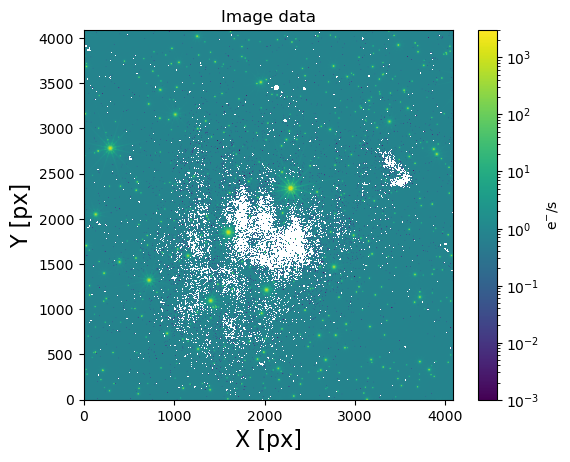

In [11]:
#NOTE: probably choose a different "prettier" image

from matplotlib.colors import LogNorm  # Optional import, this is to show image in log scale
plt.imshow(img[:, :].value, origin='lower', norm=LogNorm(1e-3, 3000))
plt.colorbar(label='e$^{-}$/s')
plt.xlabel('X [px]', fontsize=16)
plt.ylabel('Y [px]', fontsize=16)
plt.title('Image data')

And we can check things like a 1D histogram

Text(0, 0.5, 'Pixels/bin')

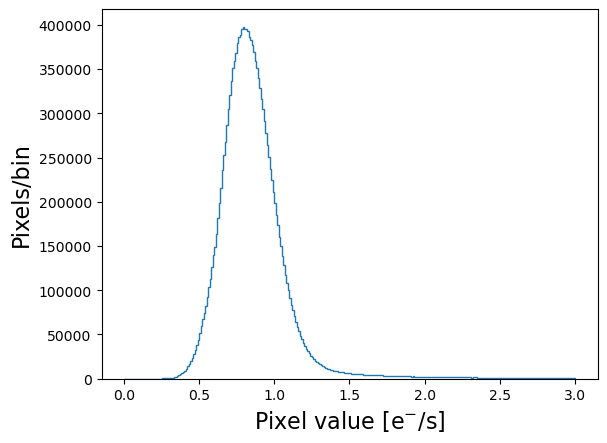

In [12]:
plt.hist(img.value.flatten(), histtype='step', range=(1e-3, 3), bins=300);
plt.xlabel('Pixel value [e$^{-}$/s]', fontsize=16)
plt.ylabel('Pixels/bin', fontsize=16)

We can explore other image blocks, for example, the data quality (DQ) flags. In this case, all of them are zero (we are dealing with a perfect simulated image), however in real data you will find a variety of flag values which are summarized [here](https://roman-pipeline.readthedocs.io/en/latest/roman/references_general/references_general.html#data-quality-flags).

Text(0.5, 1.0, 'DQ flags')

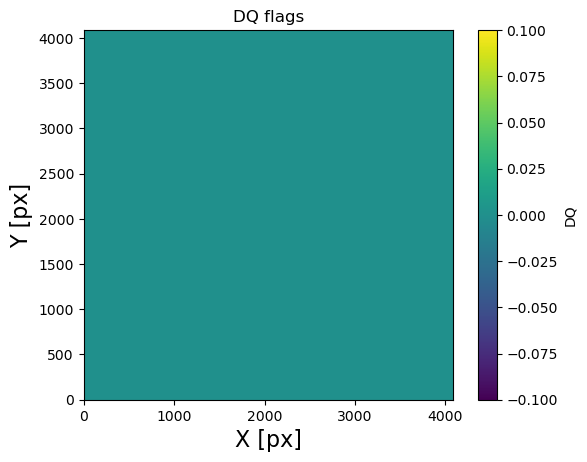

In [13]:
plt.imshow(f['roman']['dq'], origin='lower')
plt.colorbar(label='DQ')
plt.xlabel('X [px]', fontsize=16)
plt.ylabel('Y [px]', fontsize=16)
plt.title('DQ flags')

## Exploring metadata

One of the advantages of ASDF is its extendability, and the ability to store human-readable hierarchical metadata. Let's further explore the metadata in our `roman` data block.

In [14]:
meta = f['roman']['meta']  # This way we get a dictionary

In [15]:
type(meta)

dict

In [16]:
print(meta)  # Expect a long-ish output here

{'aperture': {'name': 'WFI_CEN', 'position_angle': 120}, 'cal_step': {'assign_wcs': 'INCOMPLETE', 'flat_field': 'COMPLETE', 'dark': 'COMPLETE', 'dq_init': 'COMPLETE', 'jump': 'COMPLETE', 'linearity': 'COMPLETE', 'photom': 'INCOMPLETE', 'source_detection': 'INCOMPLETE', 'outlier_detection': 'INCOMPLETE', 'ramp_fit': 'COMPLETE', 'refpix': 'COMPLETE', 'saturation': 'COMPLETE', 'skymatch': 'INCOMPLETE', 'tweakreg': 'INCOMPLETE', 'resample': 'INCOMPLETE'}, 'calibration_software_version': '0.13.0', 'coordinates': {'reference_frame': 'ICRS'}, 'ephemeris': {'earth_angle': 0.0, 'moon_angle': 0.0, 'sun_angle': 0.0, 'type': 'PREDICTED', 'time': 60360.64056133196, 'ephemeris_reference_frame': 'EME2000', 'spatial_x': 0.0, 'spatial_y': 0.0, 'spatial_z': 0.0, 'velocity_x': 0.0, 'velocity_y': 0.0, 'velocity_z': 0.0}, 'exposure': {'id': 1, 'type': 'WFI_IMAGE', 'start_time': <Time object: scale='utc' format='datetime' value=2021-01-01 00:00:00>, 'mid_time': <Time object: scale='utc' format='isot' value=

We retrieved the `meta` datablock as a dictionary, which contains a collection of dictionaries. We iterate over its keys to see what it contains

In [17]:
for key in meta.keys():
    print(key)

aperture
cal_step
calibration_software_version
coordinates
ephemeris
exposure
file_date
filename
guidestar
instrument
model_type
observation
origin
photometry
pointing
prd_software_version
program
ref_file
sdf_software_version
target
telescope
velocity_aberration
visit
wcsinfo


And we can continue going deeper in the tree

In [18]:
for key in meta['aperture'].keys():
    print(key)

name
position_angle


Alternatively, one can retrieve the data blocks as `stnode._node.DNode` objects (it requires `roman_datamodels`)

In [19]:
meta2 = f['roman'].meta

In [20]:
type(meta2)

roman_datamodels.stnode._node.DNode

And one can go deeper in the tree following the same approach

In [21]:
ap = meta2.aperture

In [22]:
type(ap)

roman_datamodels.stnode.Aperture

The advantage of this approach is that you still have access to the schema of each node

In [23]:
ap.get_schema()

{'$schema': 'asdf://stsci.edu/datamodels/roman/schemas/rad_schema-1.0.0',
 'id': 'asdf://stsci.edu/datamodels/roman/schemas/aperture-1.0.0',
 'title': 'Aperture Information',
 'type': 'object',
 'properties': {'name': {'title': 'PRD Science Aperture Used',
   'description': 'Science aperture used as defined in the Project\nReference Database (PRD).\n',
   'type': 'string',
   'enum': ['WFI_01_FULL',
    'WFI_02_FULL',
    'WFI_03_FULL',
    'WFI_04_FULL',
    'WFI_05_FULL',
    'WFI_06_FULL',
    'WFI_07_FULL',
    'WFI_08_FULL',
    'WFI_09_FULL',
    'WFI_10_FULL',
    'WFI_11_FULL',
    'WFI_12_FULL',
    'WFI_13_FULL',
    'WFI_14_FULL',
    'WFI_15_FULL',
    'WFI_16_FULL',
    'WFI_17_FULL',
    'WFI_18_FULL',
    'BORESIGHT',
    'CGI_CEN',
    'WFI_CEN'],
   'sdf': {'special_processing': 'VALUE_REQUIRED',
    'source': {'origin': 'PSS:aperture.AperName'}},
   'archive_catalog': {'datatype': 'nvarchar(40)',
    'destination': ['WFIExposure.aperture_name',
     'GuideWindow.apert

## Exploring L1 data

In the previous section we illustrated how to use `asdf` to read a level-2 image, which trims away the reference pixels and the 33rd amplifier data. In this section we will show some example usage of level-1 (raw) data.

In [24]:
path = '/grp/roman/jsanchez/dms_validation_sandbox/r0000101001001001001_01101_0001_WFI01_uncal.asdf'
f = asdf.open(path)

/user/jsanchez/linux/miniconda3/envs/roman_notebooks/lib/python3.12/site-packages/asdf/_asdf.py:359: AsdfWarning: File 'file:///grp/roman/jsanchez/dms_validation_sandbox/r0000101001001001001_01101_0001_WFI01_uncal.asdf' was created with extension URI 'asdf://astropy.org/core/extensions/core-1.5.0' (from package asdf-astropy==0.5.0), which is not currently installed
  warnings.warn(msg, AsdfWarning)


In [25]:
f.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 3.0.1
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata) ...
│   ├─[1] (ExtensionMetadata) ...
│   └─[2] (ExtensionMetadata) ...
└─roman (WfiScienceRaw) # Level 1 WFI Imaging and Spectrographic Science Data
  ├─meta (dict)
  │ ├─aperture (Aperture) # Aperture Information ...
  │ ├─cal_step (TaggedDict) ...
  │ ├─calibration_software_version (CalibrationSoftwareVersion): 0.13.0 # Calibratio (truncated)
  │ ├─coordinates (Coordinates) # Name Of The Coordinate Reference Frame ...
  │ ├─ephemeris (Ephemeris) # Ephemeris Data Information ...
  │ ├─exposure (Exposure) # Exposure Information
 ...
  │ ├─file_date (FileDate): 2024-02-20 15:23:53.066000 # File Creation Date
  │ └─16 not shown
  ├─data (Quantity): shape=(5, 4096, 4096), dtype=uint16 # Science Data (DN)
  └─amp33 (Quantity): shape=(5, 4096

Loading the data follows exactly the same procedure as before, but we see some extra (interesting) data block: `amp33`, which contains the data from the 33rd amplifier. Additionally, the images are now 4096 $\times$ 4096 pixels, which is different than the previous images with size 4088 $\times$ 4088 pixels. On top of that, our `data` array is now a 3D datacube rather than a 2D image, and the units are different ($\mathrm{DN}$ instead of $\mathrm{e}^{-}/\mathrm{s}$)

Text(0, 0.5, 'Pixel value [DN]')

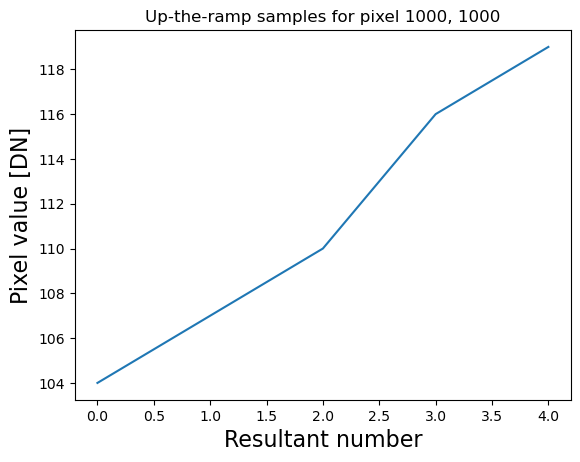

In [26]:
plt.title('Up-the-ramp samples for pixel 1000, 1000')
plt.plot(f['roman']['data'][:, 1000, 1000])
plt.xlabel('Resultant number', fontsize=16)
plt.ylabel('Pixel value [DN]', fontsize=16)

The datacube in the level-1 data contains all resultant uncalibrated images that after processing yield the ramp images in level-2 images.

## Reading data using `roman_datamodels`

All Roman data products conform to one of the data models described by the [`roman_datamodels`](https://roman-datamodels.readthedocs.io/en/latest/) package.

This package provides the `asdf` library information to validate the files, and utilities to read and save data conforming to the official data models.

We will illustrate how to use `roman_datamodels` in order to load data from an `asdf` file.

In [27]:
data_rdm = rdm.open(path)

In [28]:
print(type(data_rdm))

<class 'roman_datamodels.datamodels._datamodels.ScienceRawModel'>


`roman_datamodels` understood our level-1 data and identified it as a `ScienceRaw` model, which we explore further below.

Again, the general `.info` method gives us information about the data.

In [29]:
data_rdm.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 3.0.1
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata) ...
│   ├─[1] (ExtensionMetadata) ...
│   └─[2] (ExtensionMetadata) ...
└─roman (WfiScienceRaw) # Level 1 WFI Imaging and Spectrographic Science Data
  ├─meta (dict)
  │ ├─aperture (Aperture) # Aperture Information ...
  │ ├─cal_step (TaggedDict) ...
  │ ├─calibration_software_version (CalibrationSoftwareVersion): 0.13.0 # Calibratio (truncated)
  │ ├─coordinates (Coordinates) # Name Of The Coordinate Reference Frame ...
  │ ├─ephemeris (Ephemeris) # Ephemeris Data Information ...
  │ ├─exposure (Exposure) # Exposure Information
 ...
  │ ├─file_date (FileDate): 2024-02-20 15:23:53.066000 # File Creation Date
  │ └─16 not shown
  ├─data (Quantity): shape=(5, 4096, 4096), dtype=uint16 # Science Data (DN)
  └─amp33 (Quantity): shape=(5, 4096

In [30]:
for key in data_rdm.keys():
    print(key)

meta
data
amp33


Note that, despite the key `roman` being shown by the `.info` method, the only keys present in the `ScienceRaw` object are those inside of the `roman` group displayed! This is because `data_rdm` is not an `AsdfObject` anymore but a `ScienceRawModel` object!

But we can still retrieve its data blocks easily by instantiating its corresponding attributes/nodes or by using the keys as dictionary keys. The former method will yield the corresponding `roman_datamodels` node, whereas the latter will yield a dictionary.

In [31]:
type(data_rdm.meta), type(data_rdm['meta'])

(roman_datamodels.stnode._node.DNode, dict)

Text(0, 0.5, 'Median pixel value [DN]')

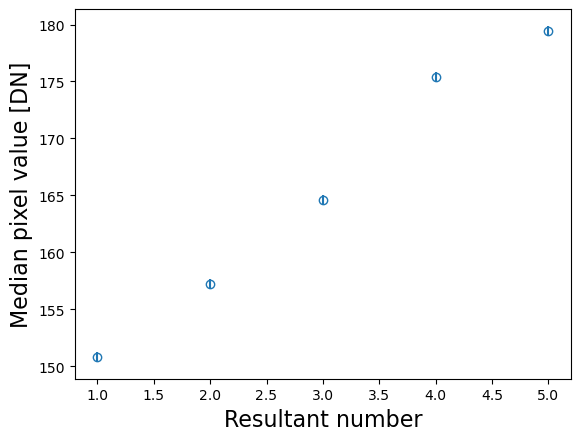

In [32]:
mean_values = np.mean(data_rdm.data.value, axis=(1, 2))
err = np.std(data_rdm.data.value, axis=(1, 2))
npix = data_rdm.data.shape[1]*data_rdm.data.shape[2]
resultant = np.arange(1, mean_values.shape[0]+1)
plt.errorbar(resultant, mean_values, err/np.sqrt(npix), marker='o', ls='none', fillstyle='none')
plt.xlabel('Resultant number', fontsize=16)
plt.ylabel('Median pixel value [DN]', fontsize=16)

## Exercises
Most notebooks are trying to convey _some_ information to their reader. It's often a good idea, if possible, to include in the notebook something where there is not an included answer so that the reader can cement in their mind how whatever it is they were supposed to learn from that notebook. If you do have exercise(s), be sure to leave a blank code cell underneath to show the user that it's meant for them to try it out right there. You may also want to include a "solutions" notebook next to your main notebook for the user to look at after they have finished their attempt.

## Aditional Resources

For more information about Roman data products and additional resources please consider visiting the links below:

- [Roman User Documentation -- RDox](https://roman-docs.stsci.edu/)
- [MAST](https://archive.stsci.edu)
- [ASDF python API](https://asdf.readthedocs.io/en/latest/)
- [ASDF standard](https://asdf-standard.readthedocs.io/)

## About this notebook
Let the world know who the author of this great notebook is! If possible/appropriate, include a contact email address for users who might need support (e.g. archive@stsci.edu)

**Author:** Javier Sánchez, Associate Scientist.  
**Updated On:** 2024-05-23

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 